In [2]:
!git clone https://github.com/microsoft/table-transformer

Cloning into 'table-transformer'...
remote: Enumerating objects: 753, done.
remote: Counting objects: 100% (432/432), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 753 (delta 338), reused 383 (delta 304), pack-reused 321
Receiving objects: 100% (753/753), 356.09 KiB | 11.49 MiB/s, done.
Resolving deltas: 100% (466/466), done.


In [3]:
!pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 50.6 MB/s eta 0:00:00


In [3]:
!git clone https://github.com/HoanChan/TNCR

Cloning into 'TNCR'...
remote: Enumerating objects: 13229, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 13229 (delta 1), reused 3 (delta 0), pack-reused 13223
Receiving objects: 100% (13229/13229), 1.79 GiB | 30.59 MiB/s, done.
Resolving deltas: 100% (6240/6240), done.
Updating files: 100% (13243/13243), done.


In [4]:
# Xử lý lại file của TNCR cho đúng định dạng của Pubtables-1M
import os
import shutil
from sklearn.model_selection import train_test_split

# Bước 1: Lập danh sách các file xml trong thư mục TNCR
data_dir = 'TNCR/TNCR'
xml_files = [file for file in os.listdir(data_dir) if file.endswith('.xml')]

# Bước 2: Chia các file thành 2 tập train và test
train_files, test_files = train_test_split(xml_files, test_size=0.2, random_state=42)

# Bước 3: Di chuyển các file tương ứng vào 2 thư mục train và test
train_dir = 'TNCR/train'
test_dir = 'TNCR/test'
image_dir = 'TNCR/images'
val_dir = 'TNCR/val'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for file_name in train_files:
    source_path = os.path.join(data_dir, file_name)
    destination_path = os.path.join(train_dir, file_name)
    shutil.move(source_path, destination_path)

for file_name in test_files:
    source_path = os.path.join(data_dir, file_name)
    destination_path = os.path.join(test_dir, file_name)
    shutil.move(source_path, destination_path)

# Bước 4: Tạo 2 file chứa danh sách file train và file test
with open('TNCR/train_filelist.txt', 'w') as train_filelist:
    train_filelist.write('train/'+'\ntrain/'.join(train_files))

with open('TNCR/test_filelist.txt', 'w') as test_filelist:
    test_filelist.write('test/'+'\ntest/'.join(test_files))

# Bước 5: Đổi tên thư mục TNCR thành image
os.rename(data_dir, image_dir)

img_files = [file for file in os.listdir(image_dir) if file.endswith('.png')]
with open('TNCR/images_filelist.txt', 'w') as images_filelist:
    images_filelist.write('images/'+'\nimages/'.join(img_files))


In [5]:
# TNCR_labels = ['full_lined', 'partial_lined_merged_cells', 'nolines', 'partial_lined', 'merged_cells']

In [6]:
# import các thư viện cần thiết
import os
import argparse
import json
from datetime import datetime
import string
import sys
import random
import numpy as np
import torch
from torch.utils.data import DataLoader

sys.path.append("/content/table-transformer/detr")
from engine import evaluate, train_one_epoch
from models import build_model
import util.misc as utils
import datasets.transforms as R


sys.path.append("/content/table-transformer/src")
import table_datasets as TD
from table_datasets import PDFTablesDataset
from eval import eval_coco

In [7]:
def get_transform(data_type, image_set):
    if data_type == 'structure':
        return TD.get_structure_transform(image_set)
    else:
        return TD.get_detection_transform(image_set)

def get_class_map(data_type):
    if data_type == 'structure':
        class_map = {
            'table': 0,
            'table column': 1,
            'table row': 2,
            'table column header': 3,
            'table projected row header': 4,
            'table spanning cell': 5,
            'no object': 6
        }
    else:
        # class_map = {'table': 0, 'table rotated': 1, 'no object': 2}
        class_map = {
            'full_lined': 0,
            'partial_lined_merged_cells': 1,
            'nolines': 2,
            'partial_lined': 3,
            'merged_cells': 4,
            'no object':  5
        }
    return class_map

In [8]:
def get_data(args):
    """
    Based on the args, retrieves the necessary data to perform training,
    evaluation or GriTS metric evaluation
    """
    # Datasets
    print("loading data")
    class_map = get_class_map(args.data_type)

    if args.mode == "train":
        dataset_train = PDFTablesDataset(
            os.path.join(args.data_root_dir, "train"),
            get_transform(args.data_type, "train"),
            do_crop=False,
            max_size=args.train_max_size,
            include_eval=False,
            max_neg=0,
            make_coco=False,
            image_extension=".png",
            xml_fileset="train_filelist.txt",
            class_map=class_map)
        dataset_val = PDFTablesDataset(os.path.join(args.data_root_dir, "val"),
                                       get_transform(args.data_type, "val"),
                                       do_crop=False,
                                       max_size=args.val_max_size,
                                       include_eval=False,
                                       make_coco=True,
                                       image_extension=".jpg",
                                       xml_fileset="val_filelist.txt",
                                       class_map=class_map)

        sampler_train = torch.utils.data.RandomSampler(dataset_train)
        sampler_val = torch.utils.data.SequentialSampler(dataset_val)

        batch_sampler_train = torch.utils.data.BatchSampler(sampler_train,
                                                            args.batch_size,
                                                            drop_last=True)

        data_loader_train = DataLoader(dataset_train,
                                       batch_sampler=batch_sampler_train,
                                       collate_fn=utils.collate_fn,
                                       num_workers=args.num_workers)
        data_loader_val = DataLoader(dataset_val,
                                     2 * args.batch_size,
                                     sampler=sampler_val,
                                     drop_last=False,
                                     collate_fn=utils.collate_fn,
                                     num_workers=args.num_workers)
        return data_loader_train, data_loader_val, dataset_val, len(
            dataset_train)

    elif args.mode == "eval":

        dataset_test = PDFTablesDataset(os.path.join(args.data_root_dir,
                                                     "test"),
                                        get_transform(args.data_type, "val"),
                                        do_crop=False,
                                        max_size=args.test_max_size,
                                        make_coco=True,
                                        include_eval=True,
                                        image_extension=".png",
                                        xml_fileset="test_filelist.txt",
                                        class_map=class_map)
        sampler_test = torch.utils.data.SequentialSampler(dataset_test)

        data_loader_test = DataLoader(dataset_test,
                                      2 * args.batch_size,
                                      sampler=sampler_test,
                                      drop_last=False,
                                      collate_fn=utils.collate_fn,
                                      num_workers=args.num_workers)
        return data_loader_test, dataset_test

    elif args.mode == "grits" or args.mode == "grits-all":
        dataset_test = PDFTablesDataset(os.path.join(args.data_root_dir,
                                                     "test"),
                                        RandomMaxResize(1000, 1000),
                                        include_original=True,
                                        max_size=args.max_test_size,
                                        make_coco=False,
                                        image_extension=".png",
                                        xml_fileset="test_filelist.txt",
                                        class_map=class_map)
        return dataset_test

In [9]:
def get_model(args, device):
    """
    Loads DETR model on to the device specified.
    If a load path is specified, the state dict is updated accordingly.
    """
    model, criterion, postprocessors = build_model(args)
    model.to(device)
    if args.model_load_path:
        print("loading model from checkpoint")
        loaded_state_dict = torch.load(args.model_load_path,
                                       map_location=device)
        model_state_dict = model.state_dict()
        pretrained_dict = {
            k: v
            for k, v in loaded_state_dict.items()
            if k in model_state_dict and model_state_dict[k].shape == v.shape
        }
        model_state_dict.update(pretrained_dict)
        model.load_state_dict(model_state_dict, strict=True)
    return model, criterion, postprocessors


In [14]:
def train(args, model, criterion, postprocessors, device):
    """
    Training loop
    """

    print("loading data")
    dataloading_time = datetime.now()
    data_loader_train, data_loader_val, dataset_val, train_len = get_data(args)
    print("finished loading data in :", datetime.now() - dataloading_time)

    model_without_ddp = model
    param_dicts = [
        {
            "params": [
                p for n, p in model_without_ddp.named_parameters()
                if "backbone" not in n and p.requires_grad
            ]
        },
        {
            "params": [
                p for n, p in model_without_ddp.named_parameters()
                if "backbone" in n and p.requires_grad
            ],
            "lr":
            args.lr_backbone,
        },
    ]
    optimizer = torch.optim.AdamW(param_dicts,
                                  lr=args.lr,
                                  weight_decay=args.weight_decay)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=args.lr_drop,
                                                   gamma=args.lr_gamma)

    max_batches_per_epoch = int(train_len / args.batch_size)
    print("Max batches per epoch: {}".format(max_batches_per_epoch))

    resume_checkpoint = False
    if args.model_load_path:
        checkpoint = torch.load(args.model_load_path, map_location='cpu')
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])

        model.to(device)

        if not args.load_weights_only and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            resume_checkpoint = True
        elif args.load_weights_only:
            print("*** WARNING: Resuming training and ignoring optimzer state. "
                  "Training will resume with new initialized values. "
                  "To use current optimizer state, remove the --load_weights_only flag.")
        else:
            print("*** ERROR: Optimizer state of saved checkpoint not found. "
                  "To resume training with new initialized values add the --load_weights_only flag.")
            raise Exception("ERROR: Optimizer state of saved checkpoint not found. Must add --load_weights_only flag to resume training without.")

        if not args.load_weights_only and 'epoch' in checkpoint:
            args.start_epoch = checkpoint['epoch'] + 1
        elif args.load_weights_only:
            print("*** WARNING: Resuming training and ignoring previously saved epoch. "
                  "To resume from previously saved epoch, remove the --load_weights_only flag.")
        else:
            print("*** WARNING: Epoch of saved model not found. Starting at epoch {}.".format(args.start_epoch))

    # Use user-specified save directory, if specified
    if args.model_save_dir:
        output_directory = args.model_save_dir
    # If resuming from a checkpoint with optimizer state, save into same directory
    elif args.model_load_path and resume_checkpoint:
        output_directory = os.path.split(args.model_load_path)[0]
    # Create new save directory
    else:
        run_date = datetime.now().strftime("%Y%m%d%H%M%S")
        output_directory = os.path.join(args.data_root_dir, "output", run_date)

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    print("Output directory: ", output_directory)
    model_save_path = os.path.join(output_directory, 'model.pth')
    print("Output model path: ", model_save_path)
    if not resume_checkpoint and os.path.exists(model_save_path):
        print("*** WARNING: Output model path exists but is not being used to resume training; training will overwrite it.")

    if args.start_epoch >= args.epochs:
        print("*** WARNING: Starting epoch ({}) is greater or equal to the number of training epochs ({}).".format(
            args.start_epoch, args.epochs
        ))

    print("Start training")
    start_time = datetime.now()
    for epoch in range(args.start_epoch, args.epochs):
        print('-' * 100)

        epoch_timing = datetime.now()
        train_stats = train_one_epoch(
            model,
            criterion,
            data_loader_train,
            optimizer,
            device,
            epoch,
            args.clip_max_norm,
            max_batches_per_epoch=max_batches_per_epoch,
            print_freq=1000)
        print("Epoch completed in ", datetime.now() - epoch_timing)

        lr_scheduler.step()

        # pubmed_stats, coco_evaluator = evaluate(model, criterion,
        #                                         postprocessors,
        #                                         data_loader_val, dataset_val,
        #                                         device, None)
        # print("pubmed: AP50: {:.3f}, AP75: {:.3f}, AP: {:.3f}, AR: {:.3f}".
        #       format(pubmed_stats['coco_eval_bbox'][1],
        #              pubmed_stats['coco_eval_bbox'][2],
        #              pubmed_stats['coco_eval_bbox'][0],
        #              pubmed_stats['coco_eval_bbox'][8]))

        # Save current model training progress
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    }, model_save_path)

        # Save checkpoint for evaluation
        if (epoch+1) % args.checkpoint_freq == 0:
            model_save_path_epoch = os.path.join(output_directory, 'model_' + str(epoch+1) + '.pth')
            torch.save(model.state_dict(), model_save_path_epoch)

    print('Total training time: ', datetime.now() - start_time)

In [11]:
# Khởi tạo các tham số.

manual_args_dict = {
    'data_root_dir': '/content/TNCR',
    'config_file': 'config.yaml',
    'backbone': 'resnet18',
    'data_type': 'detection',
    'model_load_path': None, # 'model_load_path': '/path/to/model.pth',
    'load_weights_only': True,
    'model_save_dir': '/content/models',
    'metrics_save_filepath': '/content/metrics',
    'debug_save_dir': 'debug',
    'table_words_dir': '/content/table_words',
    'mode': 'train',
    'debug': False,
    'device': 'cuda',
    'lr': 0.001,
    'lr_drop': 10,
    'lr_gamma': 0.5,
    'epochs': 50,
    'checkpoint_freq': 1,
    'batch_size': 32,
    'num_workers': 4,
    'train_max_size': 1024,
    'val_max_size': 512,
    'test_max_size': 512,
    'eval_pool_size': 1,
    'eval_step': 1,
    "lr":5e-5,
    "lr_backbone":1e-5,
    "batch_size":2,
    "weight_decay":1e-4,
    "epochs":20,
    "lr_drop":1,
    "lr_gamma":0.9,
    "clip_max_norm":0.1,
    "backbone":"resnet18",
    "num_classes":5,
    "dilation":False,
    "position_embedding":"sine",
    "emphasized_weights":{},
    "enc_layers":6,
    "dec_layers":6,
    "dim_feedforward":2048,
    "hidden_dim":256,
    "dropout":0.1,
    "nheads":8,
    "num_queries":110,
    "pre_norm":True,
    "masks":False,
    "aux_loss":False,
    "mask_loss_coef":1,
    "dice_loss_coef":1,
    "ce_loss_coef":1,
    "bbox_loss_coef":5,
    "giou_loss_coef":2,
    "eos_coef":0.4,
    "set_cost_class":1,
    "set_cost_bbox":5,
    "set_cost_giou":2,
    "device":"cuda",
    "seed":42,
    "start_epoch":0,
    "num_workers":1
}

In [15]:
config_args = manual_args_dict
args = type('Args', (object,), config_args)
print(args.__dict__)
print('-' * 100)

# Check for debug mode
if args.mode == 'eval' and args.debug:
    print("Running evaluation/inference in DEBUG mode, processing will take longer. Saving output to: {}.".format(args.debug_save_dir))
    os.makedirs(args.debug_save_dir, exist_ok=True)

# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

print("loading model")
device = torch.device(args.device)
model, criterion, postprocessors = get_model(args, device)

if args.mode == "train":
    train(args, model, criterion, postprocessors, device)
elif args.mode == "eval":
    data_loader_test, dataset_test = get_data(args)
    eval_coco(args, model, criterion, postprocessors, data_loader_test, dataset_test, device)

{'data_root_dir': '/content/TNCR', 'config_file': 'config.yaml', 'backbone': 'resnet18', 'data_type': 'detection', 'model_load_path': None, 'load_weights_only': True, 'model_save_dir': '/content/models', 'metrics_save_filepath': '/content/metrics', 'debug_save_dir': 'debug', 'table_words_dir': '/content/table_words', 'mode': 'train', 'debug': False, 'device': 'cuda', 'lr': 5e-05, 'lr_drop': 1, 'lr_gamma': 0.9, 'epochs': 20, 'checkpoint_freq': 1, 'batch_size': 2, 'num_workers': 1, 'train_max_size': 1024, 'val_max_size': 512, 'test_max_size': 512, 'eval_pool_size': 1, 'eval_step': 1, 'lr_backbone': 1e-05, 'weight_decay': 0.0001, 'clip_max_norm': 0.1, 'num_classes': 5, 'dilation': False, 'position_embedding': 'sine', 'emphasized_weights': {}, 'enc_layers': 6, 'dec_layers': 6, 'dim_feedforward': 2048, 'hidden_dim': 256, 'dropout': 0.1, 'nheads': 8, 'num_queries': 110, 'pre_norm': True, 'masks': False, 'aux_loss': False, 'mask_loss_coef': 1, 'dice_loss_coef': 1, 'ce_loss_coef': 1, 'bbox_los

RuntimeError: ignored

In [17]:
import json

# Đường dẫn tới file JSON bạn muốn ghi
json_file_path = '/content/manual_args.json'

# Ghi thông tin từ manual_args_dict vào file JSON
with open(json_file_path, 'w') as json_file:
    json.dump(manual_args_dict, json_file, indent=4)

print(f'The configuration has been saved to {json_file_path}')


The configuration has been saved to /content/manual_args.json


In [1]:
!git clone https://github.com/HoanChan/TableVision.git

Cloning into 'TableVision'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 140 (delta 15), reused 50 (delta 7), pack-reused 81
Receiving objects: 100% (140/140), 210.83 MiB | 14.66 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (73/73), done.


In [4]:
def split_pth_file(input_file, output_file1, output_file2):
    with open(input_file, 'rb') as f:
        data = f.read()

    half_len = len(data) // 2

    with open(output_file1, 'wb') as f1, open(output_file2, 'wb') as f2:
        f1.write(data[:half_len])
        f2.write(data[half_len:])

def combine_pth_files(input_file1, input_file2, output_file):
    with open(input_file1, 'rb') as f1, open(input_file2, 'rb') as f2:
        data1 = f1.read()
        data2 = f2.read()

    combined_data = data1 + data2

    with open(output_file, 'wb') as f:
        f.write(combined_data)

combine_pth_files("/content/TableVision/models/pubtables1m_detection_detr_r18.pth_part1", "/content/TableVision/models/pubtables1m_detection_detr_r18.pth_part2", "/content/TableVision/models/pubtables1m_detection_detr_r18.pth")
combine_pth_files("/content/TableVision/models/pubtables1m_structure_detr_r18.pth_part1", "/content/TableVision/models/pubtables1m_structure_detr_r18.pth_part2", "/content/TableVision/models/pubtables1m_structure_detr_r18.pth")


In [6]:
import sys
print("Before clearing sys.path:")
print(sys.path)
# print(sys.path.index('/root/.ipython'))
sys.path=sys.path[:10]
print(sys.path)

Before clearing sys.path:
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']


In [12]:
import sys
# Thêm đường dẫn đến thư mục 'src' vào danh sách đường dẫn
sys.path=sys.path[:10]

# sys.path.append('/content/TableVision/')
sys.path.append('/content/table-transformer/')
sys.path.append('/content/table-transformer/src/')
sys.path.append('/content/table-transformer/detr/')

from src.inference import TableExtractionPipeline

# Create inference pipeline
pipe = TableExtractionPipeline(det_config_path='/content/manual_args.json',
                               det_model_path='/content/models/model_13.pth', det_device='cuda',
                               str_config_path='/content/table-transformer/src/structure_config.json',
                               str_model_path='/content/TableVision/models/pubtables1m_structure_detr_r18.pth', str_device='cuda')

Detection model initialized.
Detection model weights loaded.
Structure model initialized.
Structure model weights loaded.


In [13]:
import matplotlib.pyplot as plt
from PIL import Image
from src.inference import visualize_detected_tables, visualize_cells

def detectTable(pipe, img_path):
  img = Image.open(img_path)
  tokens = {}
  extracted_tables = pipe.recognize(img, tokens, out_objects=True, out_cells=True, out_html=True, out_csv=True)

  # Select table (there could be more than one)
  try:
    extracted_table = extracted_tables[0]
  except:
    extracted_table = extracted_tables

  # Get output in desired format
  objects = extracted_table['objects']
  cells = extracted_table['cells']
  csv = extracted_table['csv']
  html = extracted_table['html']

  visualize_detected_tables(img, objects, "/content/1.jpg")
  visualize_cells(img, cells[0], "/content/2.jpg")

  img0 = Image.open(img_path)
  img1 = Image.open('/content/1.jpg')
  img2 = Image.open('/content/2.jpg')

  plt.figure(figsize=(15, 5))

  plt.subplot(131)
  plt.imshow(img0)
  plt.title('Image 0')
  plt.axis('off')

  plt.subplot(132)
  plt.imshow(img1)
  plt.title('Image 1')
  plt.axis('off')


  plt.subplot(133)
  plt.imshow(img2)
  plt.title('Image 2')
  plt.axis('off')

  plt.show()


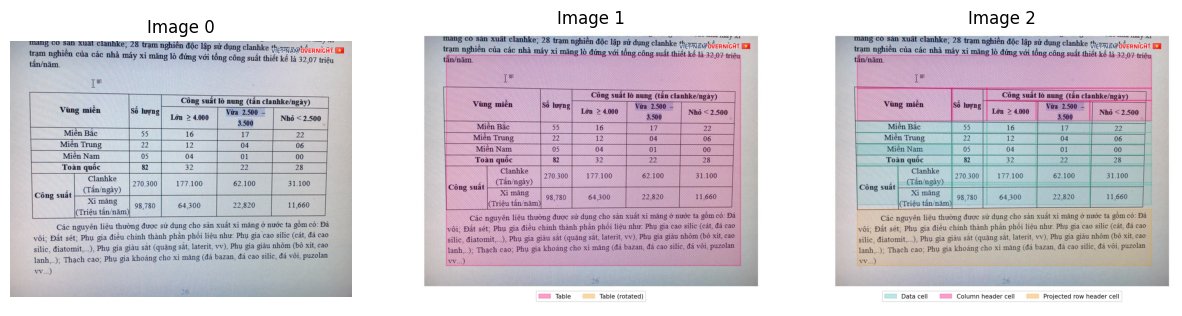

In [14]:
detectTable(pipe, "/content/TableVision/sample/vn0.jpg")

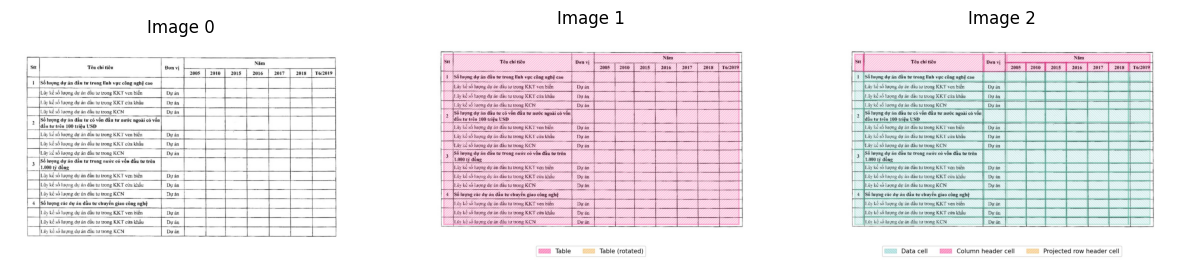

In [15]:
detectTable(pipe, "/content/TableVision/sample/vn1.jpg")

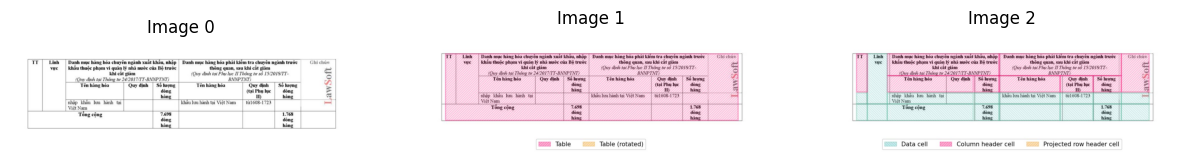

In [16]:
detectTable(pipe, "/content/TableVision/sample/vn2.jpg")

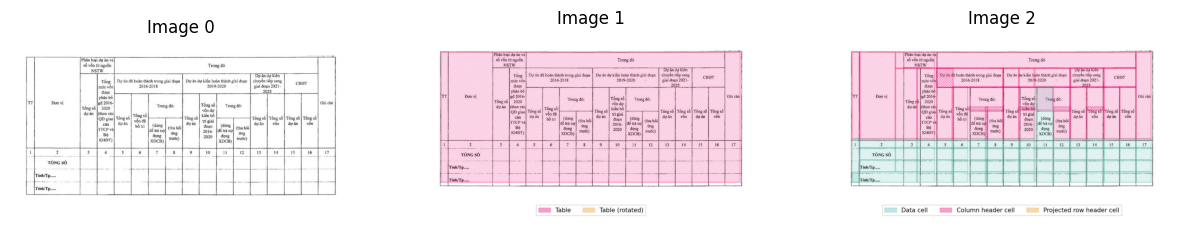

In [17]:
detectTable(pipe, "/content/TableVision/sample/vn3.jpg")

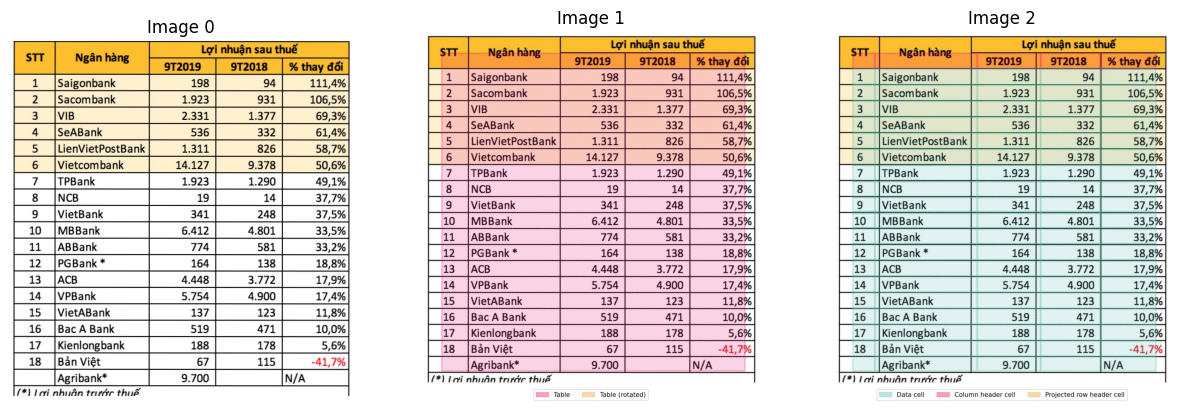

In [18]:
detectTable(pipe, "/content/TableVision/sample/vn4.jpg")

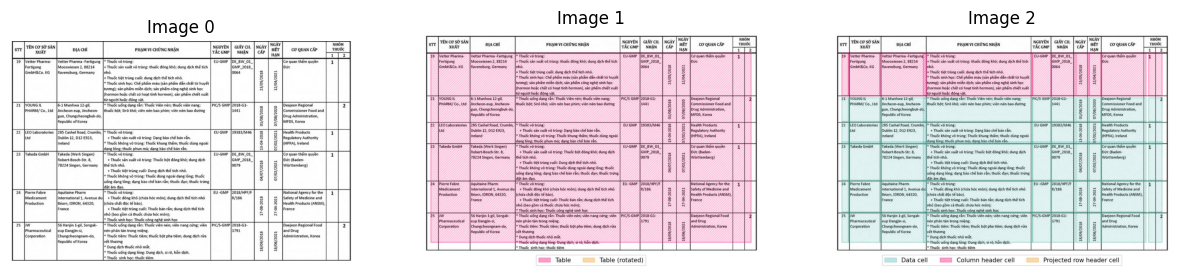

In [19]:
detectTable(pipe, "/content/TableVision/sample/vn5.jpg")

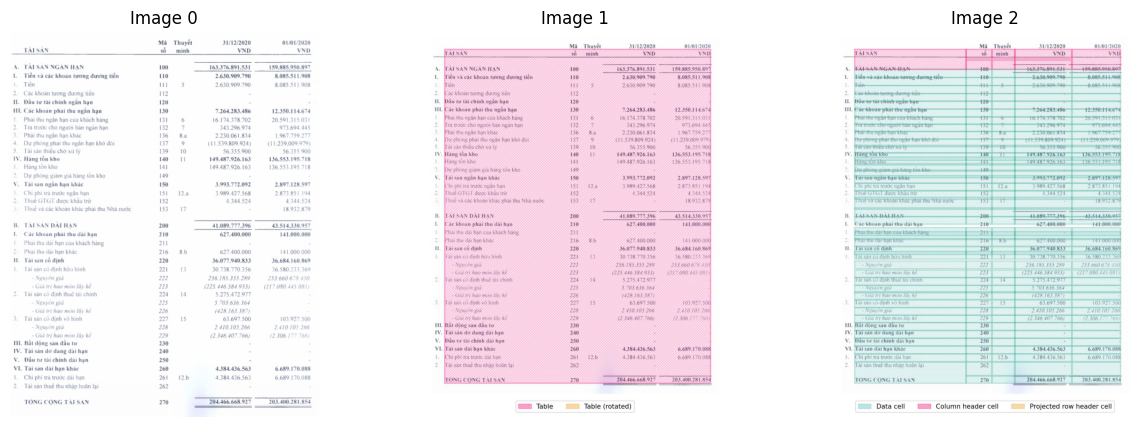

In [20]:
detectTable(pipe, "/content/TableVision/sample/vn6.jpg")

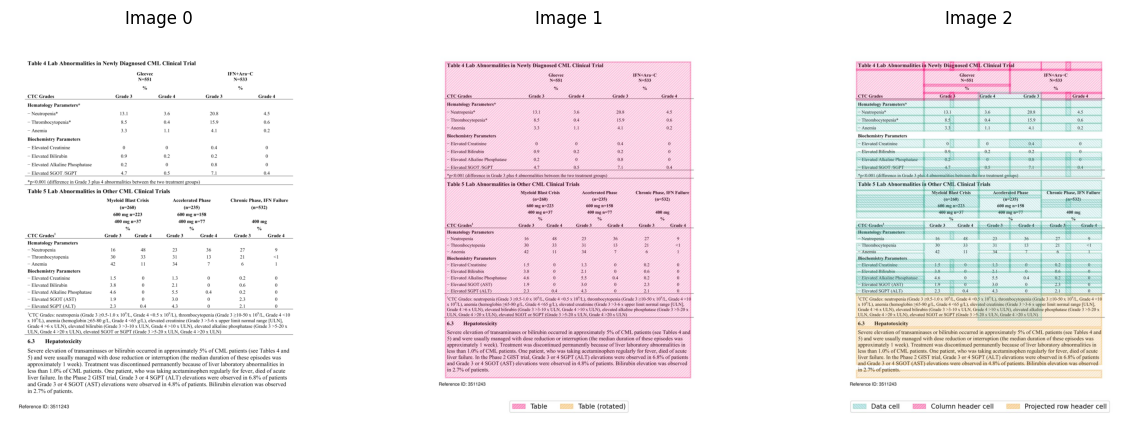

In [21]:
detectTable(pipe, "/content/TableVision/sample/tablex2.png")

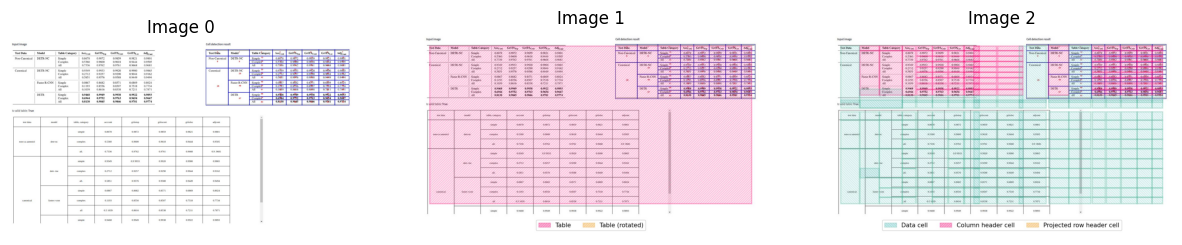

In [24]:
def convert_png_to_jpeg(png_path, jpeg_path):
    # Đọc ảnh từ file PNG
    image = Image.open(png_path)
    # Chuyển đổi và lưu ảnh dưới định dạng JPEG
    image.convert("RGB").save(jpeg_path, "JPEG")

convert_png_to_jpeg("/content/TableVision/sample/tablex3.png","/content/TableVision/sample/tablex3.jpg")
detectTable(pipe, "/content/TableVision/sample/tablex3.jpg")